# Fine-Tuning du Réseau de Neurones MLP pour la Classification COPD

Ce notebook est dédié au **fine-tuning du modèle MLP (Multi-Layer Perceptron)** pour la classification multi-classe du taux de prévalence COPD.

## Objectifs :
1. **Chargement et préparation des données** (comme dans ModelsSpecialized_9019)
2. **Architecture du MLP de base** 
3. **Grid Search / Random Search** pour trouver les meilleurs hyperparamètres
4. **Callbacks avancés** : EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
5. **Visualisation** des courbes d'apprentissage
6. **Évaluation finale** du meilleur modèle

## 1. Configuration et Imports

In [30]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Définir le chemin de base
BASE_PATH = "/mnt/c/Users/ala78/OneDrive - HESSO/BA5/GML/data-gml-health/Refined"

# Définir le dossier et fichier
folder_name = "9019"
file_name = "COPD_prevalence_rate_s_2"
file_format = "csv"

# Configuration du fine-tuning
RANDOM_STATE = 42
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.2

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, accuracy_score, 
                             precision_score, recall_score, f1_score)
from sklearn.utils import class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Keras Tuner pour l'optimisation des hyperparamètres
try:
    import keras_tuner as kt
    KERAS_TUNER_AVAILABLE = True
    print("✓ Keras Tuner disponible pour l'optimisation automatique")
except ImportError:
    KERAS_TUNER_AVAILABLE = False
    print("⚠️ Keras Tuner non installé. Installez avec: pip install keras-tuner")

# Désactiver les logs verbeux de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# Ajouter le dossier parent au path pour importer data_preparation
project_root = Path.cwd().parent    
sys.path.append(str(project_root.resolve()))

import COPD.data_preparation as data_preparation

print("✓ Imports terminés avec succès !")
print(f"  TensorFlow version: {tf.__version__}")
print(f"  GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

✓ Keras Tuner disponible pour l'optimisation automatique
✓ Imports terminés avec succès !
  TensorFlow version: 2.20.0
  GPU disponible: False


## 2. Chargement et Préparation des Données

Nous utilisons le même pipeline de préparation que dans `ModelsSpecialized_9019.ipynb` :
1. Chargement des données brutes
2. Création de la variable cible (3 classes)
3. Imputation des valeurs manquantes avec IterativeImputer
4. Feature Engineering (normalisation par population, etc.)

In [2]:
# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================
df = pd.read_csv(f"{BASE_PATH}/{folder_name}/{file_name}.{file_format}")

print("📊 Aperçu des données :")
print(f"   Forme : {df.shape}")
print(f"   Colonnes : {len(df.columns)}")
print(df.head())

# ============================================================================
# CRÉATION DE LA VARIABLE CIBLE (3 CLASSES)
# ============================================================================
try:
    df['Y_class'] = pd.qcut(df['Value'], q=3, labels=[0, 1, 2])
    df['Y_label'] = pd.qcut(df['Value'], q=3, labels=['Faible', 'Moyen', 'Élevé'])
except ValueError as e:
    print(f"⚠️ Avertissement lors du qcut : {e}")
    df['Y_class'] = pd.qcut(df['Value'], q=3, labels=[0, 1, 2], duplicates='drop')
    df['Y_label'] = pd.qcut(df['Value'], q=3, labels=['Faible', 'Moyen', 'Élevé'], duplicates='drop')

print("\n✓ Variable cible créée (0=Faible, 1=Moyen, 2=Élevé)")
print("\nDistribution des classes :")
print(df['Y_label'].value_counts())

📊 Aperçu des données :
   Forme : (5212, 44)
   Colonnes : 44
      Measure Country Name                                Disease Metric  \
0  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
1  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
2  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
3  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
4  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   

   Year        Value Country Code  \
0  1990  1193.009546          IDN   
1  1991  1214.971198          IDN   
2  1992  1237.655515          IDN   
3  1993  1260.285392          IDN   
4  1994  1282.440639          IDN   

  Access to clean fuels and technologies for cooking (% of population)  \
0                                                 ..                     
1                                                 ..                     
2                                   

In [3]:
# ============================================================================
# IMPUTATION DES VALEURS MANQUANTES
# ============================================================================

# Sauvegarder les cibles avant l'imputation
y_class_saved = df['Y_class'].copy()
y_label_saved = df['Y_label'].copy()

# Colonnes à exclure de l'imputation
cols_to_exclude = ['Measure', 'Country Name', 'Disease', 'Metric', 'Y_class', 'Y_label']
df_for_imputation = df.drop(columns=cols_to_exclude, errors='ignore').copy()

print("⏳ Étape 1/2 : Preprocessing...")
df_prepared = data_preparation.preprocessing(df_for_imputation)
print(f"   NaN après preprocessing : {df_prepared.isnull().sum().sum()}")

print("\n⏳ Étape 2/2 : Imputation avec IterativeImputer...")
df_imputed = data_preparation.impute_nans(df_prepared)
print(f"   NaN après imputation : {df_imputed.isnull().sum().sum()}")

# Récupérer les index et ajouter les cibles
df_imputed.index = df.index
df_imputed['Y_class'] = y_class_saved
df_imputed['Y_label'] = y_label_saved

# Calcul de la vitesse du vent si applicable
df_imputed = data_preparation.process_wind_speed(df_imputed)

print(f"\n✓ Données imputées ! Forme : {df_imputed.shape}")

⏳ Étape 1/2 : Preprocessing...
   NaN après preprocessing : 44284

⏳ Étape 2/2 : Imputation avec IterativeImputer...
📊 Colonnes détectées pour l'imputation : 38 colonnes

🔄 Étape 1/3 : Interpolation temporelle linéaire...
📈 Interpolation temporelle : 23985 valeurs imputées sur 38 colonnes.
   NaN restants après interpolation : 20299

🔄 Étape 2/3 : Forward/Backward fill résiduel...

🔄 Étape 3/3 : Imputation MICE (IterativeImputer)...
   NaN après imputation : 0
✅ 'Wind_Speed' calculée. Colonnes 'u10' et 'v10' non supprimées.

✓ Données imputées ! Forme : (5212, 208)


In [4]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

# Colonnes à normaliser par la population
cols_to_normalize_by_population = [
    'CO2 emissions', 'Total sales of agricultural pesticides (tonnes)',
    'Coal consumption', 'Energy use', 'Electricity use',
    'Raw materials extracted', 'Oil consumption', 'Sulfur emission',
]

# Colonnes totales à supprimer (ont déjà une version per capita)
cols_to_drop_total = ['GDP (current US$)', 'Surface area (sq. km)', 'Population, total']

# Colonnes météo redondantes
cols_meteo_redundant = ['skt', 'd2m']
cols_meteo_to_round = ['t2m', 'sst']

print("📊 FEATURE ENGINEERING")
print("="*60)

# 1. Densité de population
if 'Population, total' in df_imputed.columns and 'Surface area (sq. km)' in df_imputed.columns:
    df_imputed['Population Density (per sq. km)'] = (
        df_imputed['Population, total'] / df_imputed['Surface area (sq. km)'].replace(0, np.nan)
    )
    print("✓ Densité de population créée")

# 2. Ratios per capita
for col in cols_to_normalize_by_population:
    if col in df_imputed.columns and 'Population, total' in df_imputed.columns:
        new_col = f"{col} (per capita)"
        df_imputed[new_col] = df_imputed[col] / df_imputed['Population, total'].replace(0, np.nan)
        df_imputed = df_imputed.drop(columns=[col])
        print(f"✓ {col} → {new_col}")

# 3. Suppression des colonnes totales
for col in cols_to_drop_total:
    if col in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=[col])
        print(f"✓ Supprimé : {col}")

# 4. Traitement météo
for col in cols_meteo_redundant:
    if col in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=[col])
        print(f"✓ Supprimé (redondant) : {col}")

for col in cols_meteo_to_round:
    if col in df_imputed.columns:
        df_imputed[col] = df_imputed[col].round(2)
        print(f"✓ Arrondi : {col}")

print(f"\n✓ Forme après feature engineering : {df_imputed.shape}")

📊 FEATURE ENGINEERING
✓ Densité de population créée
✓ CO2 emissions → CO2 emissions (per capita)
✓ Coal consumption → Coal consumption (per capita)
✓ Energy use → Energy use (per capita)
✓ Electricity use → Electricity use (per capita)
✓ Raw materials extracted → Raw materials extracted (per capita)
✓ Oil consumption → Oil consumption (per capita)
✓ Sulfur emission → Sulfur emission (per capita)
✓ Supprimé : GDP (current US$)
✓ Supprimé : Surface area (sq. km)
✓ Supprimé : Population, total
✓ Supprimé (redondant) : skt
✓ Supprimé (redondant) : d2m
✓ Arrondi : t2m
✓ Arrondi : sst

✓ Forme après feature engineering : (5212, 204)


In [5]:
# ============================================================================
# PRÉPARATION FINALE DES FEATURES (X) ET CIBLE (y)
# ============================================================================

# Exclure les colonnes non-features
cols_to_exclude = ['Value', 'Y_class', 'Y_label']
all_columns = df_imputed.drop(columns=cols_to_exclude, errors='ignore').columns.tolist()

# Exclure Year et Country Code encodés
features_for_model = [col for col in all_columns 
                      if col != 'Year' and not col.startswith('Country Code_')]

# Créer le DataFrame de modélisation
df_model = df_imputed[features_for_model + ['Y_class']].copy()
df_model = df_model.dropna(subset=['Y_class'])

# Définir X et y
X = df_model.drop('Y_class', axis=1)
y = df_model['Y_class'].astype(int)

# Nettoyer les noms de colonnes pour compatibilité
def clean_feature_name(name):
    cleaned = re.sub(r'[\[\]{}\"\'<>]', '', name)
    cleaned = re.sub(r'[,;:]', '_', cleaned)
    cleaned = re.sub(r'\s+', '_', cleaned)
    return cleaned.strip('_')

original_columns = X.columns.tolist()
cleaned_columns = [clean_feature_name(col) for col in original_columns]
X.columns = cleaned_columns
feature_names = X.columns.tolist()

print(f"✓ Features finales : {len(feature_names)}")
print(f"✓ Échantillons : {len(X)}")
print(f"\nDistribution des classes :")
print(y.value_counts().sort_index())

✓ Features finales : 34
✓ Échantillons : 5212

Distribution des classes :
Y_class
0    1737
1    1737
2    1738
Name: count, dtype: int64


In [6]:
# ============================================================================
# SPLIT TRAIN/TEST ET STANDARDISATION
# ============================================================================

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Standardisation (essentiel pour les réseaux de neurones)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calcul des poids de classes pour le déséquilibre
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print(f"✓ Train: {X_train_scaled.shape[0]} échantillons")
print(f"✓ Test: {X_test_scaled.shape[0]} échantillons")
print(f"✓ Features: {X_train_scaled.shape[1]}")
print(f"\nPoids des classes (pour équilibrer) :")
for cls, weight in class_weights_dict.items():
    print(f"   Classe {cls}: {weight:.4f}")

✓ Train: 4169 échantillons
✓ Test: 1043 échantillons
✓ Features: 34

Poids des classes (pour équilibrer) :
   Classe 0: 1.0005
   Classe 1: 0.9998
   Classe 2: 0.9998


## 3. Modèle MLP de Base

Voici l'architecture de base du MLP utilisée dans `ModelsSpecialized_9019.ipynb`.
Nous allons d'abord l'entraîner pour établir une baseline avant le fine-tuning.

In [7]:
# ============================================================================
# MODÈLE MLP DE BASE (depuis ModelsSpecialized_9019)
# ============================================================================

def create_baseline_mlp(input_dim, num_classes=3):
    """
    Architecture de base du MLP (comme dans ModelsSpecialized_9019).
    """
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Créer et afficher le modèle de base
baseline_model = create_baseline_mlp(X_train_scaled.shape[1])
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,419 (17.26 KB)

 Trainable params: 4,419 (17.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ============================================================================
# ENTRAÎNEMENT DU MODÈLE DE BASE (BASELINE)
# ============================================================================

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Entraînement
print("🔄 Entraînement du modèle de base...")
tf.random.set_seed(RANDOM_STATE)

baseline_history = baseline_model.fit(
    X_train_scaled, y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=150,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

# Évaluation
y_pred_baseline = np.argmax(baseline_model.predict(X_test_scaled, verbose=0), axis=1)

print("\n" + "="*60)
print("📊 RÉSULTATS DU MODÈLE DE BASE")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_baseline, average='weighted'):.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_baseline, target_names=['Faible', 'Moyen', 'Élevé']))

🔄 Entraînement du modèle de base...
Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3775 - loss: 1.1570 - val_accuracy: 0.4616 - val_loss: 1.0561
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4045 - loss: 1.0742 - val_accuracy: 0.4904 - val_loss: 1.0277
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4429 - loss: 1.0534 - val_accuracy: 0.5264 - val_loss: 1.0120
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4678 - loss: 1.0271 - val_accuracy: 0.5504 - val_loss: 0.9852
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4987 - loss: 0.9965 - val_accuracy: 0.5635 - val_loss: 0.9546
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5214 - loss: 0.9790 - val_accuracy: 0.5791 - val_loss: 0.9258
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5286 - loss: 0.9614 - val_accuracy: 0.6175 - val_loss: 0.8999
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5502 - lo

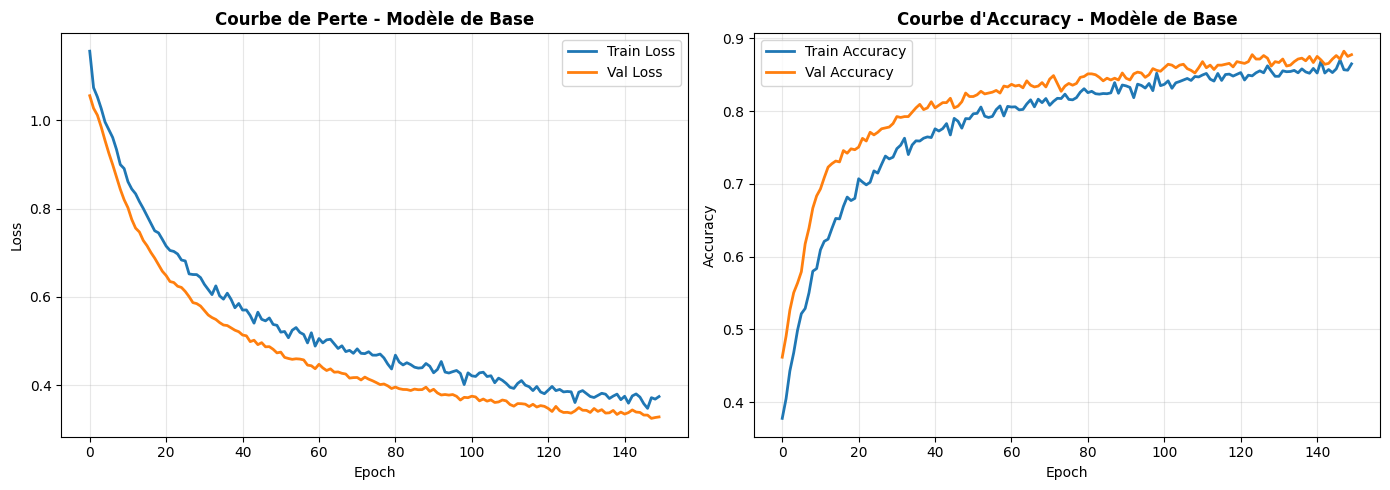

In [9]:
# ============================================================================
# VISUALISATION DES COURBES D'APPRENTISSAGE (BASELINE)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe de perte
axes[0].plot(baseline_history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(baseline_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Courbe de Perte - Modèle de Base', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Courbe d'accuracy
axes[1].plot(baseline_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(baseline_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Courbe d\'Accuracy - Modèle de Base', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Fine-Tuning Manuel avec Grid Search

Nous allons explorer différentes configurations d'hyperparamètres :
- **Architecture** : nombre de couches, nombre de neurones
- **Régularisation** : Dropout, L1/L2
- **Optimiseur** : Adam, SGD, RMSprop
- **Learning rate** : différentes valeurs
- **Batch size** : différentes tailles

In [10]:
# ============================================================================
# DÉFINITION DES HYPERPARAMÈTRES À EXPLORER
# ============================================================================

# Espace de recherche des hyperparamètres
HYPERPARAMETER_SPACE = {
    # Architecture
    'hidden_layers': [
        [64, 32],           # Baseline
        [128, 64],          # Plus large
        [128, 64, 32],      # Plus profond
        [256, 128, 64],     # Encore plus large et profond
        [64, 64, 64],       # Uniforme
        [128, 64, 32, 16],  # Pyramide
    ],
    
    # Dropout
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    
    # Learning rate
    'learning_rate': [0.001, 0.0005, 0.0001],
    
    # Batch size
    'batch_size': [16, 32, 64, 128],
    
    # Optimiseur
    'optimizer': ['adam', 'rmsprop'],
    
    # Régularisation L2
    'l2_reg': [0.0, 0.001, 0.01],
    
    # Batch Normalization
    'use_batch_norm': [True, False],
}

print("📊 ESPACE DE RECHERCHE DES HYPERPARAMÈTRES")
print("="*60)
for param, values in HYPERPARAMETER_SPACE.items():
    print(f"  {param}: {values}")

📊 ESPACE DE RECHERCHE DES HYPERPARAMÈTRES
  hidden_layers: [[64, 32], [128, 64], [128, 64, 32], [256, 128, 64], [64, 64, 64], [128, 64, 32, 16]]
  dropout_rate: [0.2, 0.3, 0.4, 0.5]
  learning_rate: [0.001, 0.0005, 0.0001]
  batch_size: [16, 32, 64, 128]
  optimizer: ['adam', 'rmsprop']
  l2_reg: [0.0, 0.001, 0.01]
  use_batch_norm: [True, False]


In [11]:
# ============================================================================
# FONCTION POUR CRÉER UN MODÈLE MLP CONFIGURABLE
# ============================================================================

def create_custom_mlp(input_dim, num_classes=3, hidden_layers=[64, 32], 
                      dropout_rate=0.3, learning_rate=0.001, 
                      optimizer='adam', l2_reg=0.0, use_batch_norm=False):
    """
    Crée un modèle MLP avec des hyperparamètres configurables.
    
    Args:
        input_dim: Dimension d'entrée
        num_classes: Nombre de classes de sortie
        hidden_layers: Liste du nombre de neurones par couche cachée
        dropout_rate: Taux de dropout
        learning_rate: Taux d'apprentissage
        optimizer: 'adam', 'sgd', ou 'rmsprop'
        l2_reg: Coefficient de régularisation L2
        use_batch_norm: Utiliser la Batch Normalization
    
    Returns:
        Modèle Keras compilé
    """
    model = Sequential()
    
    # Première couche cachée
    regularizer = l2(l2_reg) if l2_reg > 0 else None
    model.add(Dense(hidden_layers[0], activation='relu', 
                    input_shape=(input_dim,),
                    kernel_regularizer=regularizer))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Couches cachées suivantes
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu', kernel_regularizer=regularizer))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Couche de sortie
    model.add(Dense(num_classes, activation='softmax'))
    
    # Choix de l'optimiseur
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Test de la fonction
test_model = create_custom_mlp(
    input_dim=X_train_scaled.shape[1],
    hidden_layers=[128, 64, 32],
    dropout_rate=0.3,
    learning_rate=0.001,
    use_batch_norm=True
)
test_model.summary()
del test_model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,811 (61.76 KB)

 Trainable params: 15,363 (60.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
# ============================================================================
# RANDOM SEARCH MANUEL POUR TROUVER LES MEILLEURS HYPERPARAMÈTRES
# ============================================================================

from itertools import product
import time

# Nombre de configurations aléatoires à tester
N_RANDOM_CONFIGS = 20  # Ajustez selon votre temps disponible

# Générer des configurations aléatoires
def generate_random_configs(hyperparameter_space, n_configs):
    """Génère n configurations aléatoires à partir de l'espace de recherche."""
    configs = []
    for _ in range(n_configs):
        config = {}
        for param, values in hyperparameter_space.items():
            config[param] = random.choice(values)
        configs.append(config)
    return configs

random.seed(RANDOM_STATE)
random_configs = generate_random_configs(HYPERPARAMETER_SPACE, N_RANDOM_CONFIGS)

print(f"🔄 Random Search avec {N_RANDOM_CONFIGS} configurations")
print("="*60)

# Stocker les résultats
search_results = []

# Callbacks communs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

# Boucle de recherche
for idx, config in enumerate(random_configs):
    start_time = time.time()
    
    # Créer le modèle
    tf.random.set_seed(RANDOM_STATE + idx)
    model = create_custom_mlp(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=config['hidden_layers'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['learning_rate'],
        optimizer=config['optimizer'],
        l2_reg=config['l2_reg'],
        use_batch_norm=config['use_batch_norm']
    )
    
    # Entraînement
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=VALIDATION_SPLIT,
        epochs=100,
        batch_size=config['batch_size'],
        callbacks=[early_stop, reduce_lr],
        class_weight=class_weights_dict,
        verbose=0
    )
    
    # Évaluation
    y_pred = np.argmax(model.predict(X_test_scaled, verbose=0), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    elapsed = time.time() - start_time
    
    # Stocker les résultats
    result = {
        **config,
        'accuracy': acc,
        'f1_score': f1,
        'val_loss': min(history.history['val_loss']),
        'epochs_trained': len(history.history['loss']),
        'time_seconds': elapsed
    }
    search_results.append(result)
    
    # Affichage progression
    print(f"[{idx+1:2d}/{N_RANDOM_CONFIGS}] Acc: {acc:.4f} | F1: {f1:.4f} | "
          f"Layers: {config['hidden_layers']} | LR: {config['learning_rate']} | "
          f"Time: {elapsed:.1f}s")
    
    # Libérer la mémoire
    del model
    tf.keras.backend.clear_session()

print("\n✓ Recherche terminée !")

🔄 Random Search avec 20 configurations
[ 1/20] Acc: 0.8840 | F1: 0.8836 | Layers: [128, 64, 32, 16] | LR: 0.001 | Time: 23.7s
[ 2/20] Acc: 0.3260 | F1: 0.2844 | Layers: [128, 64, 32, 16] | LR: 0.0001 | Time: 7.2s
[ 3/20] Acc: 0.4957 | F1: 0.4924 | Layers: [64, 32] | LR: 0.001 | Time: 5.9s
[ 4/20] Acc: 0.3576 | F1: 0.3462 | Layers: [128, 64] | LR: 0.0001 | Time: 3.7s
[ 5/20] Acc: 0.4391 | F1: 0.4320 | Layers: [128, 64, 32] | LR: 0.001 | Time: 4.5s
[ 6/20] Acc: 0.5369 | F1: 0.5326 | Layers: [256, 128, 64] | LR: 0.0005 | Time: 3.5s
[ 7/20] Acc: 0.4487 | F1: 0.4468 | Layers: [64, 64, 64] | LR: 0.0005 | Time: 7.6s
[ 8/20] Acc: 0.3845 | F1: 0.3505 | Layers: [64, 64, 64] | LR: 0.0001 | Time: 6.4s
[ 9/20] Acc: 0.5187 | F1: 0.5063 | Layers: [128, 64, 32] | LR: 0.001 | Time: 4.9s
[10/20] Acc: 0.3941 | F1: 0.3839 | Layers: [128, 64, 32, 16] | LR: 0.001 | Time: 2.4s
[11/20] Acc: 0.3710 | F1: 0.3696 | Layers: [128, 64, 32, 16] | LR: 0.0001 | Time: 3.4s
[12/20] Acc: 0.3893 | F1: 0.3567 | Layers: [25

In [13]:
# ============================================================================
# ANALYSE DES RÉSULTATS DE LA RECHERCHE
# ============================================================================

# Créer un DataFrame des résultats
df_results = pd.DataFrame(search_results)

# Trier par F1-score
df_results = df_results.sort_values('f1_score', ascending=False).reset_index(drop=True)

# Convertir hidden_layers en string pour l'affichage
df_results['architecture'] = df_results['hidden_layers'].apply(str)

print("="*80)
print("📊 TOP 10 DES MEILLEURES CONFIGURATIONS")
print("="*80)

display_cols = ['architecture', 'dropout_rate', 'learning_rate', 'optimizer', 
                'l2_reg', 'use_batch_norm', 'batch_size', 'accuracy', 'f1_score']
print(df_results[display_cols].head(10).to_string(index=False))

# Meilleure configuration
best_config = df_results.iloc[0].to_dict()
print("\n" + "="*80)
print("🏆 MEILLEURE CONFIGURATION TROUVÉE")
print("="*80)
for key, value in best_config.items():
    if key not in ['accuracy', 'f1_score', 'val_loss', 'epochs_trained', 'time_seconds', 'architecture']:
        print(f"  {key}: {value}")
print(f"\n  ► Accuracy: {best_config['accuracy']:.4f}")
print(f"  ► F1-Score: {best_config['f1_score']:.4f}")

📊 TOP 10 DES MEILLEURES CONFIGURATIONS
     architecture  dropout_rate  learning_rate optimizer  l2_reg  use_batch_norm  batch_size  accuracy  f1_score
[128, 64, 32, 16]           0.2         0.0010      adam   0.000            True          64  0.883988  0.883604
   [256, 128, 64]           0.2         0.0005   rmsprop   0.000           False          64  0.536913  0.532585
    [128, 64, 32]           0.2         0.0010   rmsprop   0.001           False          16  0.518696  0.506267
         [64, 32]           0.3         0.0010      adam   0.010           False          16  0.495686  0.492397
     [64, 64, 64]           0.2         0.0005   rmsprop   0.010           False          16  0.448706  0.446798
        [128, 64]           0.5         0.0010      adam   0.000            True          16  0.453500  0.444751
    [128, 64, 32]           0.4         0.0010   rmsprop   0.000            True          32  0.439118  0.432041
         [64, 32]           0.4         0.0005      adam 

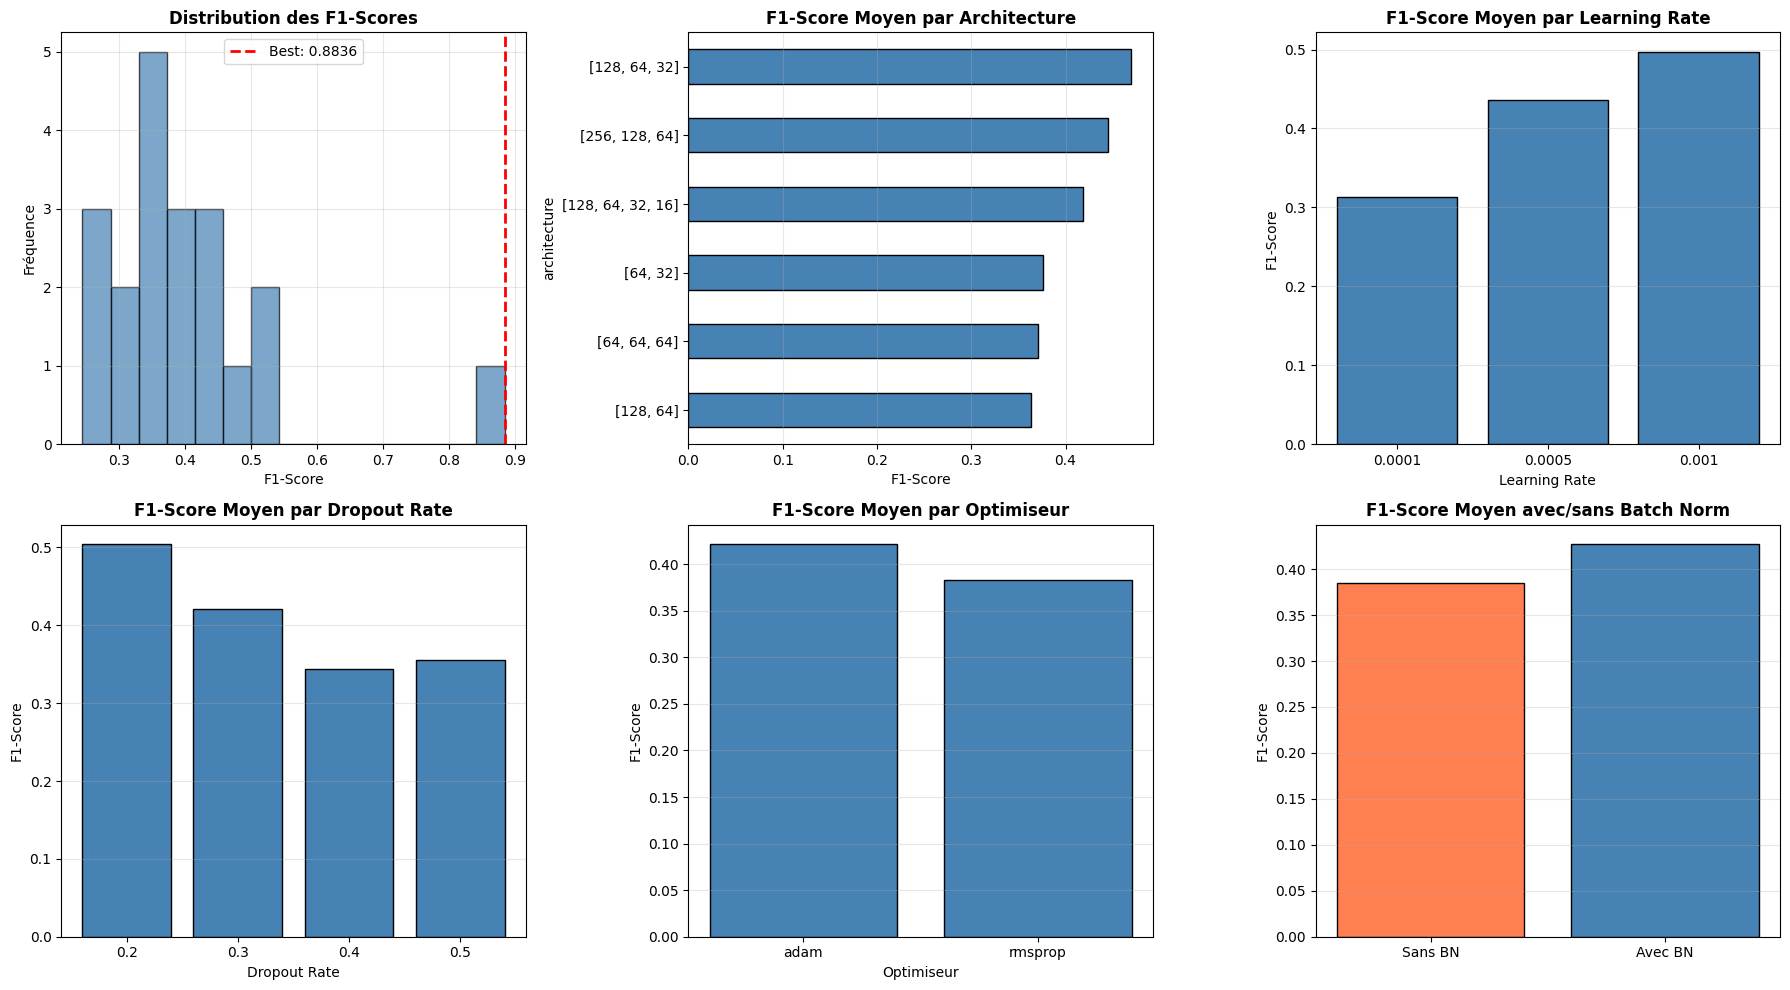

✓ Graphique sauvegardé sous 'hyperparameter_search_results.png'


In [14]:
# ============================================================================
# VISUALISATION DES RÉSULTATS DE LA RECHERCHE
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribution des F1-scores
ax = axes[0, 0]
ax.hist(df_results['f1_score'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(df_results['f1_score'].max(), color='red', linestyle='--', linewidth=2, label=f'Best: {df_results["f1_score"].max():.4f}')
ax.set_title('Distribution des F1-Scores', fontweight='bold')
ax.set_xlabel('F1-Score')
ax.set_ylabel('Fréquence')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. F1-score par architecture
ax = axes[0, 1]
arch_scores = df_results.groupby('architecture')['f1_score'].mean().sort_values(ascending=True)
arch_scores.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('F1-Score Moyen par Architecture', fontweight='bold')
ax.set_xlabel('F1-Score')
ax.grid(True, alpha=0.3, axis='x')

# 3. F1-score par learning rate
ax = axes[0, 2]
lr_scores = df_results.groupby('learning_rate')['f1_score'].mean()
ax.bar([str(lr) for lr in lr_scores.index], lr_scores.values, color='steelblue', edgecolor='black')
ax.set_title('F1-Score Moyen par Learning Rate', fontweight='bold')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('F1-Score')
ax.grid(True, alpha=0.3, axis='y')

# 4. F1-score par dropout
ax = axes[1, 0]
dropout_scores = df_results.groupby('dropout_rate')['f1_score'].mean()
ax.bar([str(d) for d in dropout_scores.index], dropout_scores.values, color='steelblue', edgecolor='black')
ax.set_title('F1-Score Moyen par Dropout Rate', fontweight='bold')
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('F1-Score')
ax.grid(True, alpha=0.3, axis='y')

# 5. F1-score par optimiseur
ax = axes[1, 1]
opt_scores = df_results.groupby('optimizer')['f1_score'].mean()
ax.bar(opt_scores.index, opt_scores.values, color='steelblue', edgecolor='black')
ax.set_title('F1-Score Moyen par Optimiseur', fontweight='bold')
ax.set_xlabel('Optimiseur')
ax.set_ylabel('F1-Score')
ax.grid(True, alpha=0.3, axis='y')

# 6. F1-score vs Batch Normalization
ax = axes[1, 2]
bn_scores = df_results.groupby('use_batch_norm')['f1_score'].mean()
ax.bar(['Sans BN', 'Avec BN'], [bn_scores.get(False, 0), bn_scores.get(True, 0)], 
       color=['coral', 'steelblue'], edgecolor='black')
ax.set_title('F1-Score Moyen avec/sans Batch Norm', fontweight='bold')
ax.set_ylabel('F1-Score')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hyperparameter_search_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graphique sauvegardé sous 'hyperparameter_search_results.png'")

## 5. Entraînement du Meilleur Modèle avec Callbacks Avancés

Maintenant que nous avons trouvé la meilleure configuration, nous allons entraîner le modèle final avec :
- **EarlyStopping** : Arrêter si pas d'amélioration
- **ReduceLROnPlateau** : Réduire le learning rate si plateau
- **ModelCheckpoint** : Sauvegarder le meilleur modèle

In [15]:
# ============================================================================
# ENTRAÎNEMENT DU MEILLEUR MODÈLE AVEC CALLBACKS AVANCÉS
# ============================================================================

# Créer le dossier pour les checkpoints
os.makedirs('models', exist_ok=True)

# Callbacks avancés
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='models/best_mlp_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Créer le meilleur modèle
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

best_model = create_custom_mlp(
    input_dim=X_train_scaled.shape[1],
    hidden_layers=best_config['hidden_layers'],
    dropout_rate=best_config['dropout_rate'],
    learning_rate=best_config['learning_rate'],
    optimizer=best_config['optimizer'],
    l2_reg=best_config['l2_reg'],
    use_batch_norm=best_config['use_batch_norm']
)

print("🏆 Entraînement du meilleur modèle trouvé...")
print("="*60)
best_model.summary()
print("="*60)

# Entraînement avec plus d'epochs
best_history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=200,
    batch_size=best_config['batch_size'],
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

print("\n✓ Entraînement terminé !")

🏆 Entraînement du meilleur modèle trouvé...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,355 (63.89 KB)

 Trainable params: 15,875 (62.01 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/200
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3678 - loss: 1.4664
Epoch 1: val_loss improved from None to 1.05975, saving model to models/best_mlp_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3796 - loss: 1.3979 - val_accuracy: 0.4221 - val_loss: 1.0597 - learning_rate: 0.0010
Epoch 2/200
36/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4238 - loss: 1.2162
Epoch 2: val_loss improved from 1.05975 to 1.01678, saving model to models/best_mlp_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4240 - loss: 1.1792 - val_accuracy: 0.4928 - val_loss: 1.0168 - learning_rate: 0.0010
Epoch 3/200
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4634 - loss: 1.0909
Epoch 3: val_loss improved from 1.01678 to 0.98119, saving model to models/best_mlp_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4681 - loss: 1.0855 - val_accuracy: 0.5048 - val_loss: 0.9812 - learning_rate: 0.0010
Epoch 4/200
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2

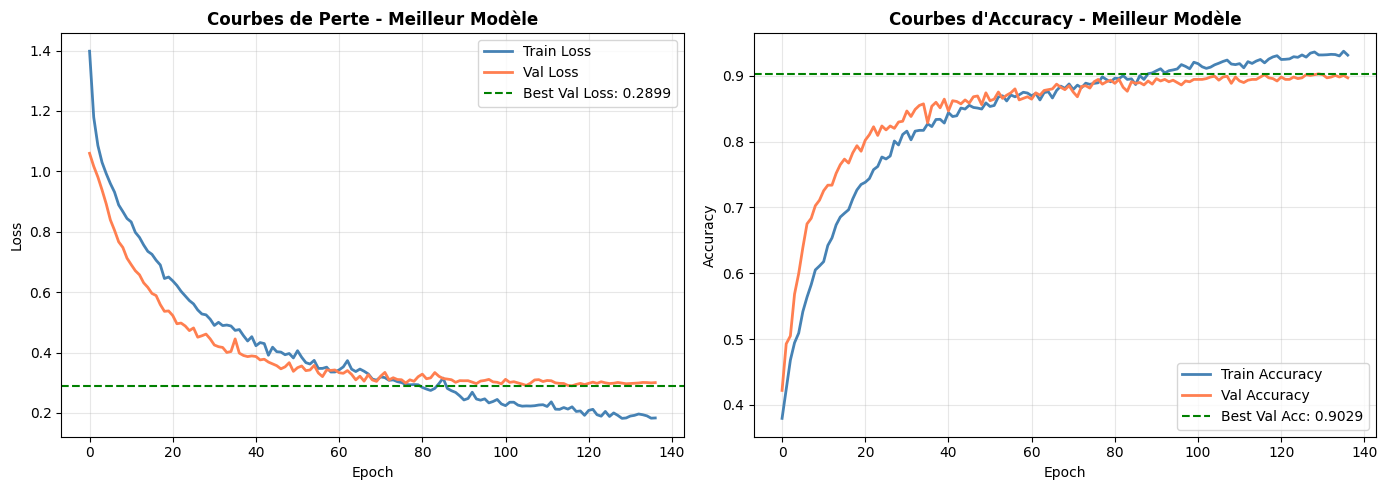

✓ Graphique sauvegardé sous 'best_model_learning_curves.png'


In [16]:
# ============================================================================
# VISUALISATION DES COURBES D'APPRENTISSAGE DU MEILLEUR MODÈLE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe de perte
ax = axes[0]
ax.plot(best_history.history['loss'], label='Train Loss', linewidth=2, color='steelblue')
ax.plot(best_history.history['val_loss'], label='Val Loss', linewidth=2, color='coral')
ax.axhline(min(best_history.history['val_loss']), color='green', linestyle='--', 
           label=f'Best Val Loss: {min(best_history.history["val_loss"]):.4f}')
ax.set_title('Courbes de Perte - Meilleur Modèle', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Courbe d'accuracy
ax = axes[1]
ax.plot(best_history.history['accuracy'], label='Train Accuracy', linewidth=2, color='steelblue')
ax.plot(best_history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='coral')
ax.axhline(max(best_history.history['val_accuracy']), color='green', linestyle='--',
           label=f'Best Val Acc: {max(best_history.history["val_accuracy"]):.4f}')
ax.set_title('Courbes d\'Accuracy - Meilleur Modèle', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graphique sauvegardé sous 'best_model_learning_curves.png'")

## 6. Évaluation Finale du Meilleur Modèle

In [17]:
# ============================================================================
# ÉVALUATION FINALE SUR LE JEU DE TEST
# ============================================================================

# Prédictions
y_pred_best = np.argmax(best_model.predict(X_test_scaled, verbose=0), axis=1)
y_pred_proba = best_model.predict(X_test_scaled, verbose=0)

# Métriques
acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')
precision_best = precision_score(y_test, y_pred_best, average='weighted')
recall_best = recall_score(y_test, y_pred_best, average='weighted')

print("="*80)
print("📊 ÉVALUATION FINALE DU MEILLEUR MODÈLE")
print("="*80)

print(f"\n🏆 MÉTRIQUES GLOBALES :")
print(f"   Accuracy:  {acc_best:.4f}")
print(f"   Precision: {precision_best:.4f}")
print(f"   Recall:    {recall_best:.4f}")
print(f"   F1-Score:  {f1_best:.4f}")

print(f"\n📋 COMPARAISON AVEC LE MODÈLE DE BASE :")
acc_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')
print(f"   Baseline - Accuracy: {acc_baseline:.4f} | F1: {f1_baseline:.4f}")
print(f"   Best     - Accuracy: {acc_best:.4f} | F1: {f1_best:.4f}")
print(f"   Amélioration F1: {(f1_best - f1_baseline)*100:.2f}%")

print("\n📊 RAPPORT DE CLASSIFICATION DÉTAILLÉ :")
print(classification_report(y_test, y_pred_best, target_names=['Faible', 'Moyen', 'Élevé']))

📊 ÉVALUATION FINALE DU MEILLEUR MODÈLE

🏆 MÉTRIQUES GLOBALES :
   Accuracy:  0.8888
   Precision: 0.8890
   Recall:    0.8888
   F1-Score:  0.8879

📋 COMPARAISON AVEC LE MODÈLE DE BASE :
   Baseline - Accuracy: 0.8639 | F1: 0.8641
   Best     - Accuracy: 0.8888 | F1: 0.8879
   Amélioration F1: 2.37%

📊 RAPPORT DE CLASSIFICATION DÉTAILLÉ :
              precision    recall  f1-score   support

      Faible       0.88      0.93      0.91       348
       Moyen       0.89      0.81      0.85       347
       Élevé       0.89      0.93      0.91       348

    accuracy                           0.89      1043
   macro avg       0.89      0.89      0.89      1043
weighted avg       0.89      0.89      0.89      1043



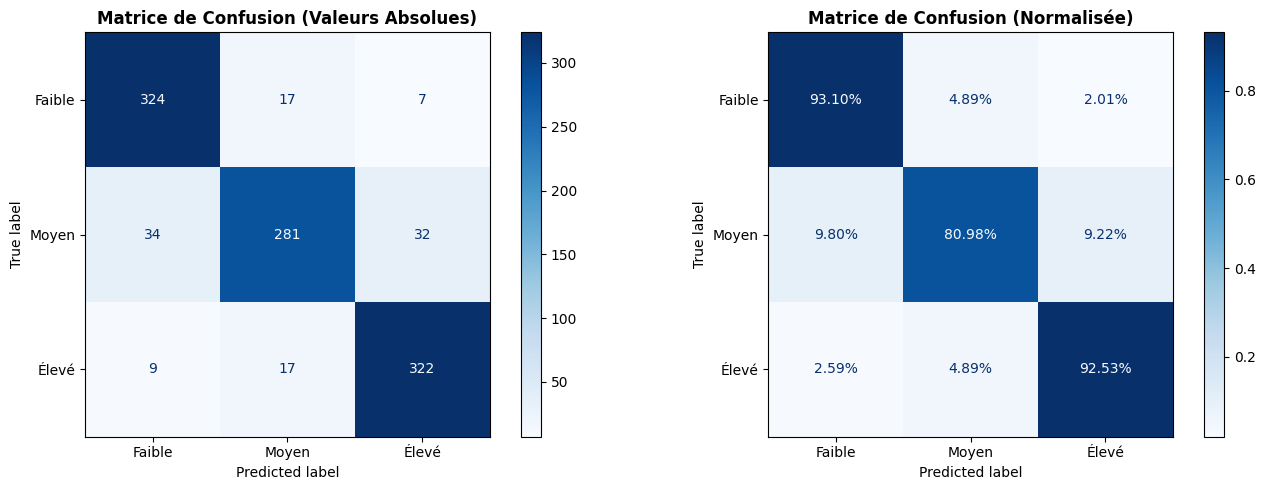

✓ Graphique sauvegardé sous 'best_model_confusion_matrix.png'


In [18]:
# ============================================================================
# MATRICE DE CONFUSION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion - valeurs absolues
cm = confusion_matrix(y_test, y_pred_best)
disp1 = ConfusionMatrixDisplay(cm, display_labels=['Faible', 'Moyen', 'Élevé'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matrice de Confusion (Valeurs Absolues)', fontweight='bold')

# Matrice de confusion - normalisée
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=['Faible', 'Moyen', 'Élevé'])
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Matrice de Confusion (Normalisée)', fontweight='bold')

plt.tight_layout()
plt.savefig('best_model_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graphique sauvegardé sous 'best_model_confusion_matrix.png'")

## 7. Keras Tuner (Optionnel - Recherche Automatique Avancée)

Si `keras-tuner` est installé, nous pouvons utiliser une recherche plus sophistiquée avec Bayesian Optimization.

In [31]:
# ============================================================================
# KERAS TUNER - RECHERCHE AUTOMATIQUE (si disponible)
# ============================================================================

if KERAS_TUNER_AVAILABLE:
    print("🔄 Utilisation de Keras Tuner pour une recherche plus approfondie...")
    
    def build_model_for_tuner(hp):
        """Fonction de construction du modèle pour Keras Tuner."""
        model = Sequential()
        
        # Première couche
        model.add(Dense(
            units=hp.Choice('units_1', [64, 128, 256]),
            activation='relu',
            input_shape=(X_train_scaled.shape[1],),
            kernel_regularizer=l2(hp.Choice('l2_reg', [0.0, 0.001, 0.01]))
        ))
        
        if hp.Boolean('use_batch_norm_1'):
            model.add(BatchNormalization())
        
        model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
        
        # Couches cachées optionnelles
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(
                units=hp.Choice(f'units_{i+2}', [32, 64, 128]),
                activation='relu'
            ))
            if hp.Boolean(f'use_batch_norm_{i+2}'):
                model.add(BatchNormalization())
            model.add(Dropout(hp.Float(f'dropout_{i+2}', 0.1, 0.5, step=0.1)))
        
        # Couche de sortie
        model.add(Dense(3, activation='softmax'))
        
        # Optimiseur
        learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
        
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        else:
            opt = RMSprop(learning_rate=learning_rate)
        
        model.compile(
            optimizer=opt,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    # Créer le tuner (Bayesian Optimization)
    tuner = kt.BayesianOptimization(
        build_model_for_tuner,
        objective='val_accuracy',
        max_trials=30,
        directory='keras_tuner_results',
        project_name='mlp_copd_tuning',
        overwrite=True
    )
    
    # Afficher l'espace de recherche
    tuner.search_space_summary()
    
else:
    print("⚠️ Keras Tuner non disponible. Installez avec: pip install keras-tuner")

🔄 Utilisation de Keras Tuner pour une recherche plus approfondie...
Search space summary
Default search space size: 10
units_1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
l2_reg (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.001, 0.01], 'ordered': True}
use_batch_norm_1 (Boolean)
{'default': False, 'conditions': []}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
use_batch_norm_2 (Boolean)
{'default': False, 'conditions': []}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordere

In [32]:
# ============================================================================
# LANCER LA RECHERCHE KERAS TUNER (si disponible)
# ============================================================================

if KERAS_TUNER_AVAILABLE:
    # Callbacks pour la recherche
    search_callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    print("🔄 Recherche en cours (peut prendre plusieurs minutes)...")
    
    # Lancer la recherche
    tuner.search(
        X_train_scaled, y_train,
        validation_split=VALIDATION_SPLIT,
        epochs=100,
        batch_size=32,
        callbacks=search_callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )
    
    # Afficher les meilleurs résultats
    print("\n" + "="*60)
    print("🏆 MEILLEURS HYPERPARAMÈTRES TROUVÉS PAR KERAS TUNER")
    print("="*60)
    tuner.results_summary(num_trials=5)
    
    # Récupérer le meilleur modèle
    best_hps = tuner.get_best_hyperparameters()[0]
    print("\nMeilleure configuration :")
    for hp in best_hps.values:
        print(f"  {hp}: {best_hps.values[hp]}")
else:
    print("⚠️ Section ignorée - Keras Tuner non disponible")

Trial 30 Complete [00h 00m 24s]
val_accuracy: 0.8872901797294617

Best val_accuracy So Far: 0.9172661900520325
Total elapsed time: 00h 15m 52s

🏆 MEILLEURS HYPERPARAMÈTRES TROUVÉS PAR KERAS TUNER
Results summary
Results in keras_tuner_results/mlp_copd_tuning
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 13 summary
Hyperparameters:
units_1: 128
l2_reg: 0.01
use_batch_norm_1: False
dropout_1: 0.2
num_layers: 2
units_2: 64
use_batch_norm_2: False
dropout_2: 0.1
learning_rate: 0.001
optimizer: adam
units_3: 64
use_batch_norm_3: False
dropout_3: 0.4
units_4: 128
use_batch_norm_4: True
dropout_4: 0.2
Score: 0.9172661900520325

Trial 14 summary
Hyperparameters:
units_1: 64
l2_reg: 0.01
use_batch_norm_1: False
dropout_1: 0.1
num_layers: 3
units_2: 128
use_batch_norm_2: False
dropout_2: 0.2
learning_rate: 0.001
optimizer: adam
units_3: 32
use_batch_norm_3: False
dropout_3: 0.4
units_4: 128
use_batch_norm_4: True
dropout_4: 0.1
Score: 0.9124700427055359

Trial 20 s

## 8. Sauvegarde et Export du Modèle Final

In [33]:
# ============================================================================
# SAUVEGARDE DU MODÈLE ET DES RÉSULTATS
# ============================================================================

import json
import pickle

# 1. Sauvegarder le modèle Keras
best_model.save('models/final_mlp_model.keras')
print("✓ Modèle sauvegardé : models/final_mlp_model.keras")

# 2. Sauvegarder le scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler sauvegardé : models/scaler.pkl")

# 3. Sauvegarder la configuration
config_to_save = {
    'hidden_layers': best_config['hidden_layers'],
    'dropout_rate': best_config['dropout_rate'],
    'learning_rate': best_config['learning_rate'],
    'optimizer': best_config['optimizer'],
    'l2_reg': best_config['l2_reg'],
    'use_batch_norm': best_config['use_batch_norm'],
    'batch_size': best_config['batch_size'],
    'feature_names': feature_names,
    'num_features': len(feature_names),
    'num_classes': 3,
    'class_labels': ['Faible', 'Moyen', 'Élevé'],
    'metrics': {
        'accuracy': float(acc_best),
        'f1_score': float(f1_best),
        'precision': float(precision_best),
        'recall': float(recall_best)
    }
}

with open('models/model_config.json', 'w') as f:
    json.dump(config_to_save, f, indent=2)
print("✓ Configuration sauvegardée : models/model_config.json")

# 4. Sauvegarder les résultats de la recherche
df_results.to_csv('models/hyperparameter_search_results.csv', index=False)
print("✓ Résultats de recherche sauvegardés : models/hyperparameter_search_results.csv")

print("\n" + "="*60)
print("📁 FICHIERS SAUVEGARDÉS DANS LE DOSSIER 'models/'")
print("="*60)

✓ Modèle sauvegardé : models/final_mlp_model.keras
✓ Scaler sauvegardé : models/scaler.pkl
✓ Configuration sauvegardée : models/model_config.json
✓ Résultats de recherche sauvegardés : models/hyperparameter_search_results.csv

📁 FICHIERS SAUVEGARDÉS DANS LE DOSSIER 'models/'


In [34]:
# ============================================================================
# FONCTION POUR CHARGER ET UTILISER LE MODÈLE SAUVEGARDÉ
# ============================================================================

def load_and_predict(model_path='models/final_mlp_model.keras', 
                     scaler_path='models/scaler.pkl',
                     config_path='models/model_config.json'):
    """
    Charge le modèle sauvegardé et effectue des prédictions.
    
    Usage:
        model, scaler, config = load_and_predict()
        # Préparer vos nouvelles données X_new (DataFrame avec les mêmes colonnes)
        X_new_scaled = scaler.transform(X_new)
        predictions = model.predict(X_new_scaled)
        predicted_classes = np.argmax(predictions, axis=1)
    """
    import json
    import pickle
    from tensorflow.keras.models import load_model
    
    # Charger le modèle
    model = load_model(model_path)
    
    # Charger le scaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    
    # Charger la configuration
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    print(f"✓ Modèle chargé avec {config['num_features']} features")
    print(f"✓ Classes : {config['class_labels']}")
    print(f"✓ Métriques du modèle : Accuracy={config['metrics']['accuracy']:.4f}, F1={config['metrics']['f1_score']:.4f}")
    
    return model, scaler, config

# Test de chargement
print("📦 Test de chargement du modèle sauvegardé :")
loaded_model, loaded_scaler, loaded_config = load_and_predict()

# Vérification sur le jeu de test
y_pred_loaded = np.argmax(loaded_model.predict(X_test_scaled, verbose=0), axis=1)
print(f"\n✓ Vérification : Accuracy sur test = {accuracy_score(y_test, y_pred_loaded):.4f}")

📦 Test de chargement du modèle sauvegardé :
✓ Modèle chargé avec 34 features
✓ Classes : ['Faible', 'Moyen', 'Élevé']
✓ Métriques du modèle : Accuracy=0.8888, F1=0.8879

✓ Vérification : Accuracy sur test = 0.8888


## 9. Résumé Final et Prochaines Étapes

### 📊 Récapitulatif du Fine-Tuning

Ce notebook a effectué :
1. **Préparation des données** identique à ModelsSpecialized_9019
2. **Baseline** : Modèle MLP simple (64-32 neurones)
3. **Random Search** : Exploration de différentes architectures et hyperparamètres
4. **Entraînement final** avec callbacks avancés (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)

### 🚀 Prochaines Étapes
- **Cross-Validation** : Utiliser K-Fold pour une évaluation plus robuste
- **Ensemble** : Combiner plusieurs modèles MLP
- **Interprétabilité** : Utiliser SHAP ou LIME pour expliquer les prédictions
- **Augmentation des données** : Si le dataset est petit

In [35]:
# ============================================================================
# RÉSUMÉ FINAL
# ============================================================================

print("="*80)
print("🎯 RÉSUMÉ FINAL DU FINE-TUNING MLP")
print("="*80)

print("\n📊 CONFIGURATION DU MEILLEUR MODÈLE :")
print(f"   Architecture : {best_config['hidden_layers']}")
print(f"   Dropout : {best_config['dropout_rate']}")
print(f"   Learning Rate : {best_config['learning_rate']}")
print(f"   Optimiseur : {best_config['optimizer']}")
print(f"   Régularisation L2 : {best_config['l2_reg']}")
print(f"   Batch Normalization : {best_config['use_batch_norm']}")
print(f"   Batch Size : {best_config['batch_size']}")

print("\n📈 PERFORMANCES :")
print(f"   {'Métrique':<15} {'Baseline':>12} {'Best Model':>12} {'Amélioration':>12}")
print(f"   {'-'*51}")
print(f"   {'Accuracy':<15} {acc_baseline:>12.4f} {acc_best:>12.4f} {(acc_best-acc_baseline)*100:>+11.2f}%")
print(f"   {'F1-Score':<15} {f1_baseline:>12.4f} {f1_best:>12.4f} {(f1_best-f1_baseline)*100:>+11.2f}%")

print("\n📁 FICHIERS GÉNÉRÉS :")
print("   • models/final_mlp_model.keras - Modèle Keras sauvegardé")
print("   • models/scaler.pkl - StandardScaler pour le preprocessing")
print("   • models/model_config.json - Configuration et métriques")
print("   • models/hyperparameter_search_results.csv - Tous les résultats de recherche")
print("   • hyperparameter_search_results.png - Visualisation de la recherche")
print("   • best_model_learning_curves.png - Courbes d'apprentissage")
print("   • best_model_confusion_matrix.png - Matrice de confusion")

print("\n" + "="*80)
print("✅ Fine-tuning terminé avec succès !")
print("="*80)

🎯 RÉSUMÉ FINAL DU FINE-TUNING MLP

📊 CONFIGURATION DU MEILLEUR MODÈLE :
   Architecture : [128, 64, 32, 16]
   Dropout : 0.2
   Learning Rate : 0.001
   Optimiseur : adam
   Régularisation L2 : 0.0
   Batch Normalization : True
   Batch Size : 64

📈 PERFORMANCES :
   Métrique            Baseline   Best Model Amélioration
   ---------------------------------------------------
   Accuracy              0.8639       0.8888       +2.49%
   F1-Score              0.8641       0.8879       +2.37%

📁 FICHIERS GÉNÉRÉS :
   • models/final_mlp_model.keras - Modèle Keras sauvegardé
   • models/scaler.pkl - StandardScaler pour le preprocessing
   • models/model_config.json - Configuration et métriques
   • models/hyperparameter_search_results.csv - Tous les résultats de recherche
   • hyperparameter_search_results.png - Visualisation de la recherche
   • best_model_learning_curves.png - Courbes d'apprentissage
   • best_model_confusion_matrix.png - Matrice de confusion

✅ Fine-tuning terminé avec su